In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/anksya/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

# Transferring content

(1, 720, 576, 3)


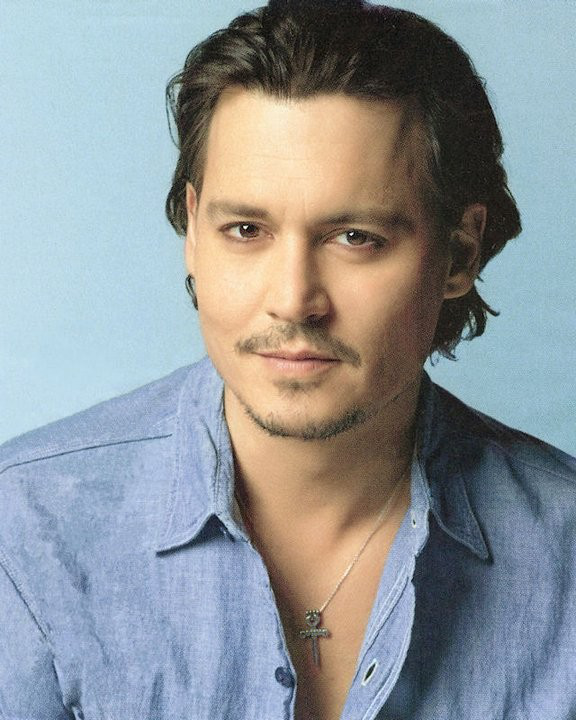

In [157]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

img=Image.open('img/johnny');
img_arr = preproc(np.expand_dims(np.array(img), 0))

shp = img_arr.shape
print(shp)
img


In [158]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [159]:
model = VGG16_Avg(include_top=False)

In [160]:
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [161]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [162]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

In [163]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [164]:
#print (Evaluator.shp)
#plt.imshow(img);
#plt.imshow(Image.open('img/sparrow').resize((500,500)))
print (shp)

(1, 720, 576, 3)


(1, 720, 576, 3)


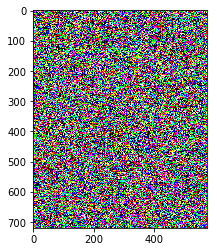

In [165]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
#x = Image.open('img/sparrow').resize((500,500))
#x = np.expand_dims(np.array(x), 0)
print (x.shape)
plt.imshow(x[0])

In [166]:
iterations=10

In [167]:
x = solve_image(evaluator, iterations, x)

Current loss value: 39.2739372253
Current loss value: 17.3384628296
Current loss value: 11.4904699326
Current loss value: 8.58732509613
Current loss value: 6.96052360535
Current loss value: 5.95504760742
Current loss value: 5.25570774078
Current loss value: 4.73837614059
Current loss value: 4.52515077591
Current loss value: 4.41265916824


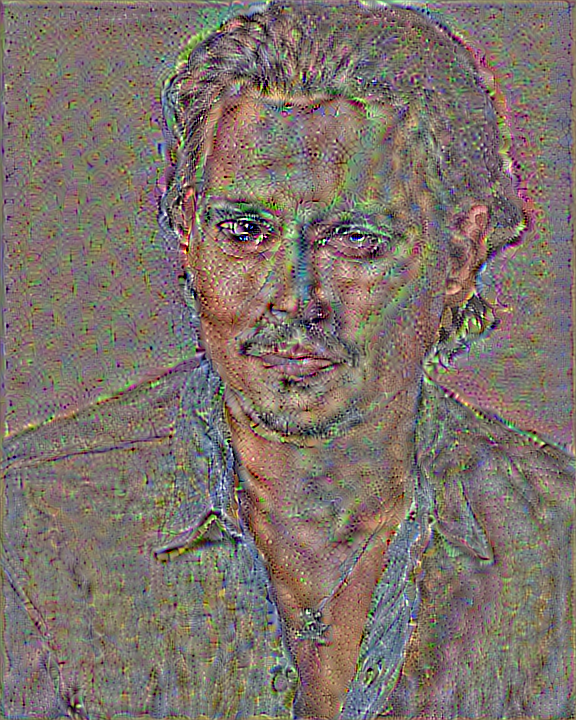

In [168]:
Image.open('results/res_at_iteration_9.png')

# Transferring style

In [46]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

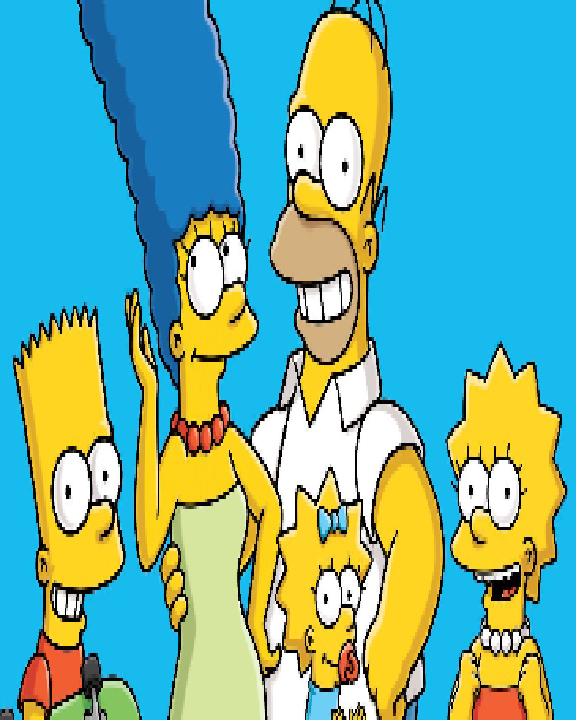

In [169]:
style = Image.open('img/simpson')
style = style.resize(np.divide(style.size,3.5).astype('int32')); 
style = style.resize(img.size)
style

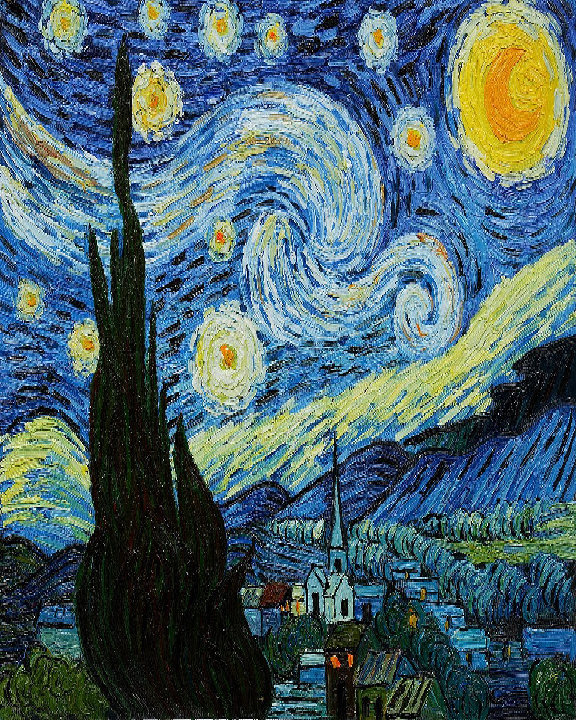

In [208]:
style = Image.open('img/starnight')
style = style.resize(np.divide(style.size,2).astype('int32')); 
style = style.resize(img.size)
style

In [209]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape
print(shp)

model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

(1, 720, 576, 3)


In [210]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,4)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]


In [211]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [212]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [213]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [214]:
iterations=10
x = rand_img(shp)

In [215]:
x = solve_image(evaluator, iterations, x)

Current loss value: 50989.3554688
Current loss value: 2336.609375
Current loss value: 741.784179688
Current loss value: 459.794219971
Current loss value: 335.123809814
Current loss value: 269.165100098
Current loss value: 208.256484985
Current loss value: 168.309188843
Current loss value: 131.133377075
Current loss value: 109.400985718


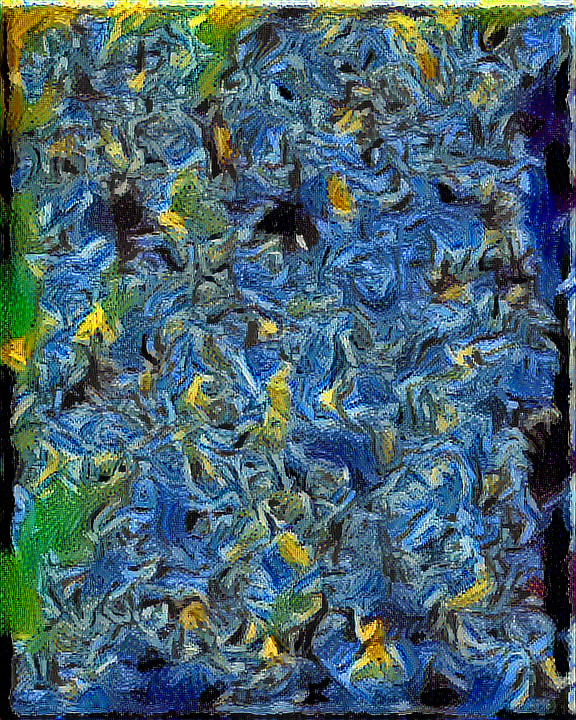

In [216]:
Image.open('results/res_at_iteration_9.png')

# Combining Content and Style transfer togeather

(576, 720)


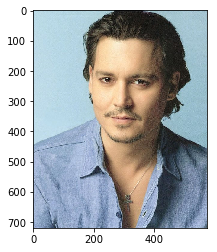

In [217]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)
#plot_arr(img_arr.resize((style.size)))
print(style.size)

In [218]:
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]
#print (style_layers,content_layer)

In [219]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [220]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [221]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, style_targs))/10
loss += metrics.mse(content_layer, content_targ)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [222]:
evaluator = Evaluator(transfer_fn, shp)


In [223]:
iterations=10
x = rand_img(shp)

In [224]:
x = solve_image(evaluator, iterations, x)

Current loss value: 8266.93652344
Current loss value: 2083.32543945
Current loss value: 1540.32043457
Current loss value: 1339.91162109
Current loss value: 1238.6809082
Current loss value: 1172.90783691
Current loss value: 1119.91455078
Current loss value: 1082.01989746
Current loss value: 1045.60656738
Current loss value: 1016.64080811


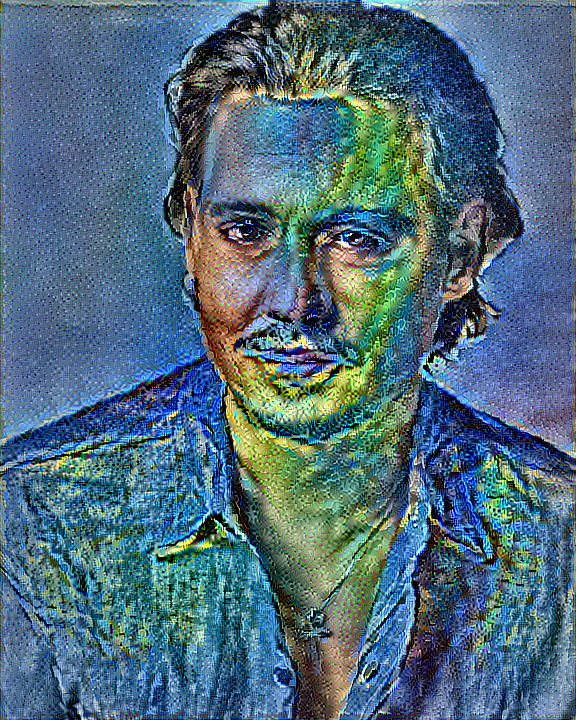

In [225]:
Image.open('results/res_at_iteration_9.png')